### Preprocess iEEG data

In [2]:
#utilise script
import re
from fractions import Fraction
from scipy.signal import resample_poly
import numpy as np

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    l.sort( key=alphanum_key )

def resample(x, sr1, sr2, axis=0):
    '''sr1: target, sr2: source'''
    a, b = Fraction(sr1, sr2)._numerator, Fraction(sr1, sr2)._denominator
    return resample_poly(x, a, b, axis).astype(np.float32)

def smooth_signal(y, n):
    box = np.ones(n)/n
    ys = np.convolve(y, box, mode='same')
    return ys

def zscore(x):
    return (x - np.mean(x, 0, keepdims=True)) / np.std(x, 0, keepdims=True)

In [3]:
import numpy as np
import mne
import pandas as pd
import mne_bids
import os

#from utils import resample, smooth_signal

### Specify subject's directory and meta-information 

In [5]:
bids_dir='/environment/notebooks/speech2brain2speech/data'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')

subject = '01'
acquisition = 'clinical'
task = 'film'
datatype = 'ieeg'
session = 'iemu'

### Load channels

In [6]:
channels_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='channels',
                                    extension='tsv',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
channels = pd.read_csv(str(channels_path.match()[0]), sep='\t', header=0, index_col=None)

/tmp/ipykernel_418/3115014924.py:1: FutureWarning: extension should start with a period ".", but got: "tsv". Prepending "." to form: ".tsv". This will raise an exception starting with MNE-BIDS 0.12.
  channels_path = mne_bids.BIDSPath(subject=subject,


### Load data information

In [7]:
data_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='ieeg',
                                    extension='vhdr',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
raw = mne.io.read_raw_brainvision(str(data_path.match()[0]), scale=1.0, preload=False, verbose=True)
raw.set_channel_types({ch_name: str(x).lower()
                if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
                                for ch_name, x in zip(raw.ch_names, channels['type'].values)})
raw.drop_channels([raw.ch_names[i] for i, j in enumerate(raw.get_channel_types()) if j == 'misc'])

/tmp/ipykernel_418/2865297635.py:1: FutureWarning: extension should start with a period ".", but got: "vhdr". Prepending "." to form: ".vhdr". This will raise an exception starting with MNE-BIDS 0.12.
  data_path = mne_bids.BIDSPath(subject=subject,


Extracting parameters from /environment/notebooks/speech2brain2speech/data/sub-01/ses-iemu/ieeg/sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...


/tmp/ipykernel_418/2865297635.py:10: RuntimeWarning: The unit for channel(s) AH+, ECG+, EMG+, MKR1+, MKR2+, ORB+, abdo+, thor+ has changed from V to NA.
  raw.set_channel_types({ch_name: str(x).lower()


<RawBrainVision | sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 103 x 860254 (420.0 s), ~106 kB, data not loaded>

### Discard bad channels

In [8]:
bad_channels = channels['name'][(channels['type'].isin(['ECOG', 'SEEG'])) & (channels['status'] == 'bad')].tolist()
raw.info['bads'].extend([ch for ch in bad_channels])
raw.drop_channels(raw.info['bads'])

<RawBrainVision | sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 101 x 860254 (420.0 s), ~104 kB, data not loaded>

### Load raw data

In [9]:
raw.load_data()

Reading 0 ... 860253  =      0.000 ...   420.045 secs...


<RawBrainVision | sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 101 x 860254 (420.0 s), ~663.0 MB, data loaded>

In [10]:
checkdata = raw.get_data()

In [11]:
checkdata.shape

(101, 860254)

### Apply notch filter to remove line noise

In [12]:
raw.notch_filter(freqs=np.arange(50, 251, 50))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    9.3s finished


<RawBrainVision | sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 101 x 860254 (420.0 s), ~663.0 MB, data loaded>

### Apply common average reference to remove common noise and trends

In [13]:
raw_car, _ = mne.set_eeg_reference(raw.copy(), 'average')

sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.


### Extract signal in gamma range, use Hilbert transform, but can also play around with wavelet decomposition options

In [14]:
gamma = raw_car.copy().filter(60, 120).apply_hilbert(envelope=True).get_data().T

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 60 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 451 samples (0.220 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    2.0s finished


In [15]:
# temp = mne.time_frequency.tfr_array_morlet(np.expand_dims(self.raw_car.copy()._data, 0), # (n_epochs, n_channels, n_times)
#                                                      sfreq=self.raw.info['sfreq'],
#                                                      freqs=np.arange(60, 120),
#                                                      verbose=True,
#                                                      n_cycles=4.,
#                                                      n_jobs=1)
# gamma = np.mean(np.abs(temp), 2).squeeze().T

### Read annotation with event markers

Used Annotations descriptions: ['Stimulus/end task', 'Stimulus/music', 'Stimulus/speech']
Using matplotlib as 2D backend.


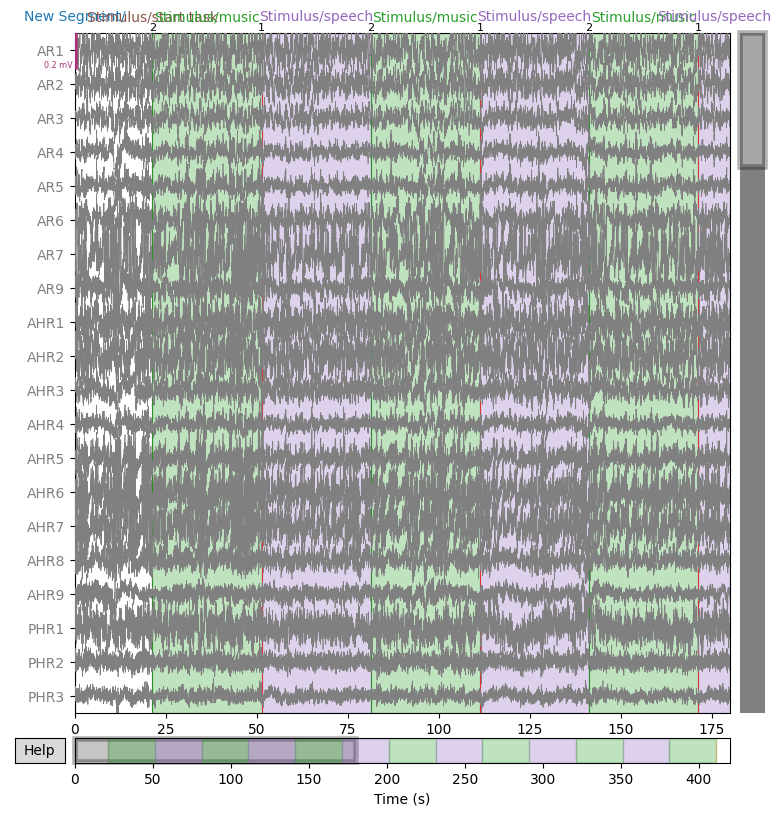

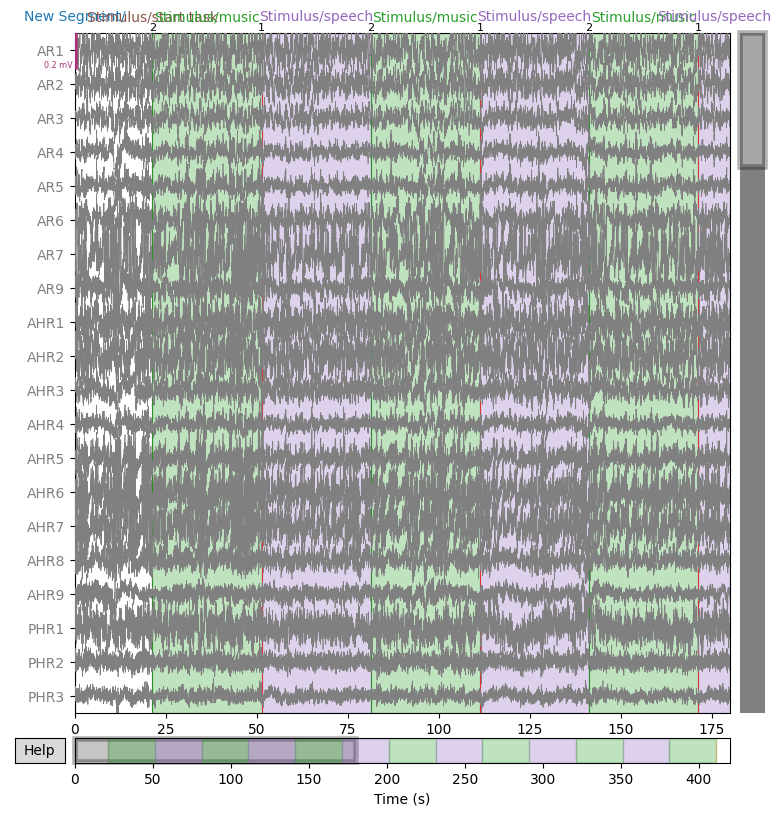

In [16]:
custom_mapping = {'Stimulus/music': 2, 'Stimulus/speech': 1,
                  'Stimulus/end task': 5}  # 'Stimulus/task end' in laan
events, event_id = mne.events_from_annotations(raw_car, event_id=custom_mapping,
                                                         use_rounding=False)

raw_car.plot(events=events, start=0, duration=180, color='gray', event_color={2: 'g', 1: 'r'}, bgcolor='w')

    
  ## **Cut speaking parts**

In [17]:
mne.Epochs

mne.epochs.Epochs

In [18]:
event_id = {'Stimulus/speech': 1}
tmin, tmax = -0.5, 0.5  # define the time window around the event
epochs = mne.Epochs(raw_car, events, event_id, tmin, tmax)


Not setting metadata
6 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [19]:
duringspeech=epochs.get_data()

Using data from preloaded Raw for 6 events and 2049 original time points ...
0 bad epochs dropped


In [20]:
duringspeech

array([[[ 7.60367157e-05,  7.50426220e-05,  7.57244106e-05, ...,
         -2.46814717e-06, -2.75330514e-06, -7.07292709e-07],
        [ 9.44641037e-05,  9.41441945e-05,  9.57615637e-05, ...,
         -1.38398858e-05, -1.13373967e-05, -1.27202460e-05],
        [ 8.63324913e-05,  8.55889647e-05,  8.40793549e-05, ...,
         -1.52627262e-05, -1.56393654e-05, -1.34589982e-05],
        ...,
        [ 6.29359627e-06,  8.08309765e-06,  1.16931194e-05, ...,
          2.55129264e-05,  2.38869631e-05,  2.17785032e-05],
        [-2.61497692e-05, -1.89312567e-05, -9.85097456e-06, ...,
          3.21123159e-05,  2.35511306e-05,  1.69656869e-05],
        [-2.71613264e-05, -2.07826298e-05, -1.36205766e-05, ...,
          2.31100006e-05,  1.52636628e-05,  9.75878725e-06]],

       [[-5.02559052e-06, -7.56599389e-06, -8.41629043e-06, ...,
         -5.74685325e-05, -5.78988688e-05, -5.65590985e-05],
        [-4.14476041e-06, -3.83990843e-06, -3.45293705e-06, ...,
         -2.65983355e-05, -2.53158376e

### Crop signal to start and end of the task

In [21]:
gamma_cropped = gamma[events[0, 0]:events[-1, 0]]

### Resample signal to a lower sampling rate

In [22]:
gamma_resampled = resample(gamma_cropped, 25, int(raw.info['sfreq']))